In [1]:
# | default_exp diff_scratch

%load_ext autoreload
%autoreload 2

# Diffusion model from scratch

In [2]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
#from diffusers import DDPMScheduler, UNet2DModel
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
from matplotlib import pyplot as plt
from icecream import ic
import numpy as np
from datetime import datetime
from cop_diffusion.utils import save_model, load_model

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


In [3]:
dataset = torchvision.datasets.MNIST(
    root="mnist/", train=True, download=True, transform=torchvision.transforms.ToTensor()
)

Input shape: torch.Size([8, 1, 28, 28])
Labels: tensor([8, 1, 5, 7, 6, 0, 2, 6])


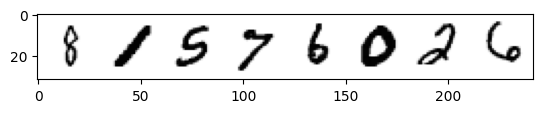

In [4]:
train_dataloader = DataLoader(dataset, batch_size=8, shuffle=True)
x, y = next(iter(train_dataloader))
print("Input shape:", x.shape)
print("Labels:", y)
plt.imshow(torchvision.utils.make_grid(x)[0], cmap="Greys")

## Corruption process

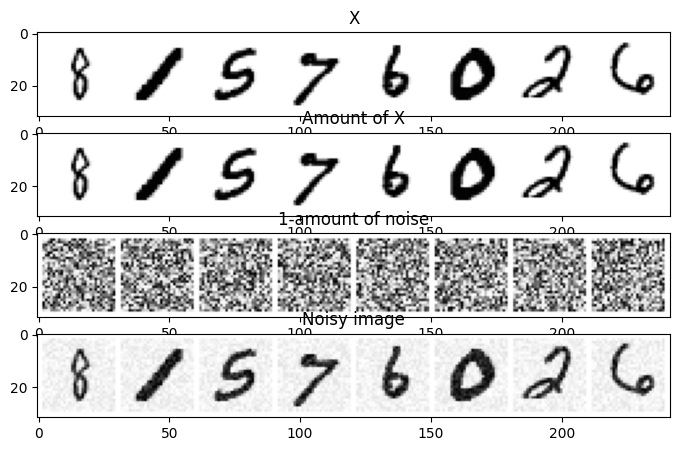

In [5]:
noise = torch.rand_like(x)
amount = .2
noisy_x = (1-amount)*x + amount*noise


fig, axs = plt.subplots(4, 1, figsize=(15, 5))
axs[0].set_title("X")
axs[0].imshow(torchvision.utils.make_grid(x)[0], cmap="Greys")

axs[1].set_title("Amount of X")
axs[1].imshow(torchvision.utils.make_grid(x*(1-amount))[0], cmap="Greys")

axs[2].set_title("1-amount of noise")
axs[2].imshow(torchvision.utils.make_grid(noise*amount)[0], cmap="Greys")


axs[3].set_title("Noisy image")
axs[3].imshow(torchvision.utils.make_grid(noisy_x)[0], cmap="Greys")

In [6]:
def corrupt(x, amount):
    """Corrupt the input `x` by mixing it with noise according to `amount`"""
    noise = torch.rand_like(x)
    amount = amount.view(-1, 1, 1, 1)  # Sort shape so broadcasting works
    return x * (1 - amount) + noise * amount


tensor([0.0000, 0.1429, 0.2857, 0.4286, 0.5714, 0.7143, 0.8571, 1.0000])


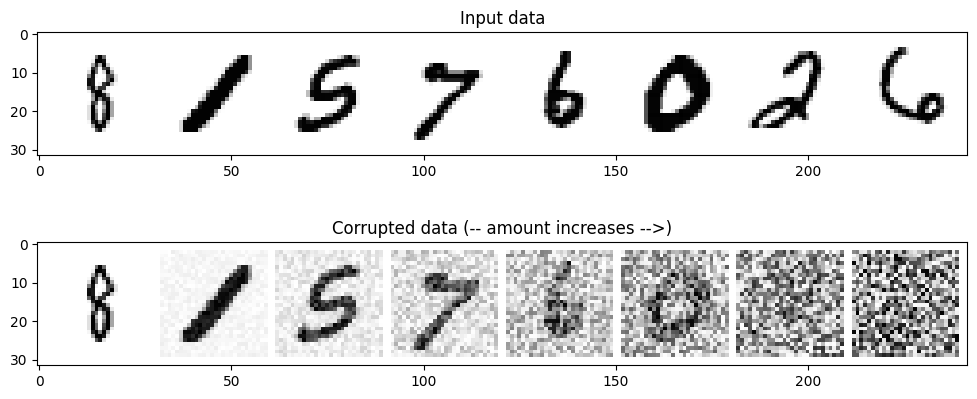

In [7]:
# Plotting the input data
fig, axs = plt.subplots(2, 1, figsize=(12, 5))
axs[0].set_title("Input data")
axs[0].imshow(torchvision.utils.make_grid(x)[0], cmap="Greys")

# Adding noise
amount = torch.linspace(0, 1, x.shape[0])
print(amount)  # Left to right -> more corruption
noised_x = corrupt(x, amount)

# Plotting the noised version
axs[1].set_title("Corrupted data (-- amount increases -->)")
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0], cmap="Greys")

## Model to learn noise

We’d like a model that takes in a 28px noisy images and outputs a prediction of the same shape.

**UNet** consists of a ‘constricting path’ through which data is compressed down and an ‘expanding path’ through which it expands back up to the original dimension (similar to an autoencoder) but also features skip connections that allow for information and gradients to flow across at different levels.

![UNET](../res/unet.png)


### See convolution_101.ipynb for better understanding of convolutions

![Convolution_101](./convolution_101.ipynb)


In [8]:
class BasicUNet(nn.Module):
    """A minimal UNet implementation."""
    #TODO: add time embedding and a class embedding

    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()
        self.down_layers = torch.nn.ModuleList(
            [
                nn.Conv2d(in_channels, 32, kernel_size=5, padding=2),
                nn.Conv2d(32, 64, kernel_size=5, padding=2),
                nn.Conv2d(64, 64, kernel_size=5, padding=2),
            ]
        )
        self.up_layers = torch.nn.ModuleList(
            [
                nn.Conv2d(64, 64, kernel_size=5, padding=2),
                nn.Conv2d(64, 32, kernel_size=5, padding=2),
                nn.Conv2d(32, out_channels, kernel_size=5, padding=2),
            ]
        )
        self.act = nn.SiLU()  # The activation function
        self.downscale = nn.MaxPool2d(2)
        self.upscale = nn.Upsample(scale_factor=2)

    def forward(self, x, t):
        h = []
        for i, l in enumerate(self.down_layers):
            x = self.act(l(x))  # Through the layer and the activation function
            if i < 2:  # For all but the third (final) down layer:
                h.append(x)  # Storing output for skip connection
                x = self.downscale(x)  # Downscale ready for the next layer

        for i, l in enumerate(self.up_layers):
            if i > 0:  # For all except the first up layer
                x = self.upscale(x)  # Upscale
                x += h.pop()  # Fetching stored output (skip connection)
            x = self.act(l(x))  # Through the layer and the activation function

        return x

ic| t.shape: torch.Size([8])
ic| ux.shape: torch.Size([8, 1, 28, 28])
    x.shape: torch.Size([8, 1, 28, 28])


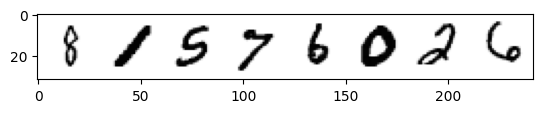

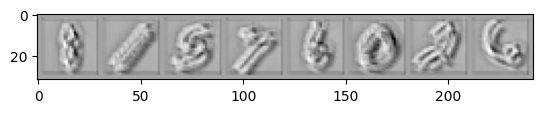

In [13]:

model = BasicUNet()
#x = torch.rand(8, 1, 28, 28)
t = torch.zeros(x.shape[0]).to(device)
ic(t.shape)
ux = model(x,t)
ic(ux.shape, x.shape)
plt.imshow(torchvision.utils.make_grid(x)[0], cmap="Greys")
plt.show()
plt.imshow(torchvision.utils.make_grid(ux)[0], cmap="Greys")
plt.show()


### Understand the UNET

In [20]:
def show_channel(input, channel_nb:int=0, info=""):
    '''You must provide on image of shape (batch, channel, height, width)convolved on many channels'''
    title = f"channel {channel_nb}, info: {info}"
    img = input[channel_nb].cpu().detach().numpy()
    plt.figure(figsize=(1, 1))
    plt.imshow(img)
    plt.title(title)
    plt.axis("off")  # Turn off axis labels
    plt.show()

ic| x.shape: torch.Size([8, 1, 28, 28])
ic| c0.shape: torch.Size([8, 32, 28, 28])
ic| cd0.shape: torch.Size([8, 32, 14, 14])


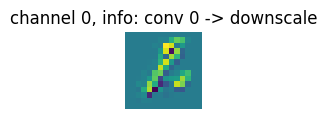

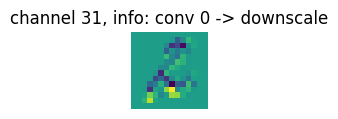

ic| cd1.shape: torch.Size([8, 64, 7, 7])


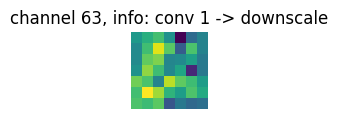

ic| u0.shape: torch.Size([8, 64, 14, 14])


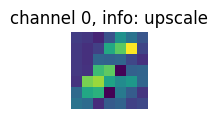

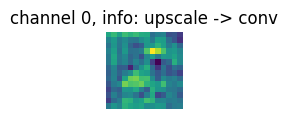

In [21]:
in_channels=1
out_channels=1
ic(x.shape)
c0 = nn.Conv2d(in_channels, 32, kernel_size=5, padding=2)(x)
ic(c0.shape);
downscale = nn.MaxPool2d(2)
cd0 = downscale(c0)
ic(cd0.shape)
show_channel(cd0[0],channel_nb=0, info='conv 0 -> downscale' )
show_channel(cd0[0],channel_nb=31, info='conv 0 -> downscale' )


c1 = nn.Conv2d(32, 64, kernel_size=5, padding=2)(cd0)
cd1 = downscale(c1)
ic(cd1.shape)
show_channel(cd1[0], channel_nb=63,info='conv 1 -> downscale' )

# Decoding part
upscale = nn.Upsample(scale_factor=2)
u0 = upscale(cd1)
ic(u0.shape)
show_channel(u0[0],channel_nb=0, info='upscale')
uc0 = nn.Conv2d(64, 64, kernel_size=5, padding=2)(u0)
show_channel(uc0[:,0],channel_nb=0, info='upscale -> conv')


### Train the UNet model (DDPM)

https://github.com/nickd16/Diffusion-Models-from-Scratch

In [22]:
class DDPM_Scheduler(nn.Module):
    def __init__(self, num_time_steps: int=1000):
        super().__init__()
        self.beta = torch.linspace(1e-4, 0.02, num_time_steps, requires_grad=False)
        alpha = 1 - self.beta
        self.alpha = torch.cumprod(alpha, dim=0).requires_grad_(False)

    def forward(self, t):
        return self.beta[t], self.alpha[t]

scheduler = DDPM_Scheduler(num_time_steps=1000)
ic(scheduler(999))
ic(scheduler(0));

ic| scheduler(999): (tensor(0.0200), tensor(4.0358e-05))
ic| scheduler(0): (tensor(1.0000e-04),

 tensor(0.9999))


In [23]:
num_time_steps = 500
scheduler = DDPM_Scheduler(num_time_steps=num_time_steps)


model_version = "0.1"
model_name = "mnist_ddpm"
batch_size = 128


n_epoch = 20
last_epoch = 20


do_train:bool=False
if do_train:
    train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    if last_epoch > 0:
        model = load_model(
            model_name=model_name, model_version=model_version, iter=last_epoch
        )
        from_epoch_nb = last_epoch + 1
    else:
        model = BasicUNet().to(device)
        from_epoch_nb = 0

    writer = SummaryWriter(
            f"../runs/{model_name}_{model_version}/{datetime.now().strftime('%m-%d-%Y_%H:%M:%S')}"
        )
    log_interval:int=50
    # The training loop
    criterion = nn.MSELoss(reduction='mean')
    lr=2e-5
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    nb_batches = len(train_dataloader)
    with tqdm(
        total=(n_epoch+1-from_epoch_nb) * nb_batches,
        desc=f"Training update",
        unit="batch",
    ) as pbar:
        for epoch in range(from_epoch_nb, n_epoch+1):
            total_loss = 0
            for batch_nb, (x, y) in enumerate(train_dataloader):
                x = x.to(device)
                n,c,w,h = x.shape
                # we may exhaust the loader and have a smaller batch
                t = torch.randint(0, num_time_steps,(n,))
                noise = torch.randn_like(x, requires_grad=False)

                a = scheduler.alpha[t].view(n,1,1,1).to(device)
                #ic(t.shape, e.shape, a.shape)
                x = (torch.sqrt(a)*x) + (torch.sqrt(1-a)*noise)

                output = model(x)
                optimizer.zero_grad()
                loss = criterion(output, noise)
                total_loss += loss.item()
                loss.backward()
                optimizer.step()

                i = (epoch*nb_batches) + batch_nb
                writer.add_scalar(f"train loss", loss.item(), (epoch*nb_batches) + batch_nb)
                if i % log_interval == 0:
                    for name, kernel_weight in model.named_parameters():
                        writer.add_histogram(name, kernel_weight,i )

                pbar.update(1)
                pbar.set_postfix({
                        "epoch": epoch,
                        "batch_nb": batch_nb,
                        #"train_loss": f"{loss.item():.4f}",
                    })
                ...
        save_model(model=model, model_name=model_name, model_version=model_version, iter=epoch)
else:
    model = load_model(model_name=model_name, model_version=model_version, iter=last_epoch)

In [24]:
num_time_steps

500

ic| x.shape: torch.Size([1, 1, 32, 32])
    x.squeeze(0).shape: torch.Size([1, 32, 32])


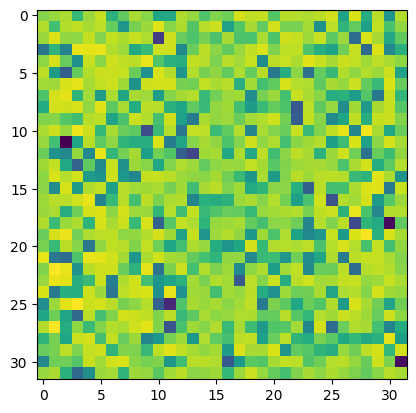

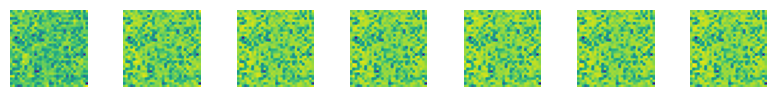

ic| x.shape: torch.Size([1, 1, 32, 32])
    x.squeeze(0).shape: torch.Size([1, 32, 32])


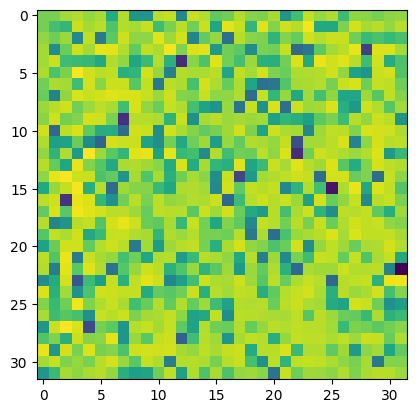

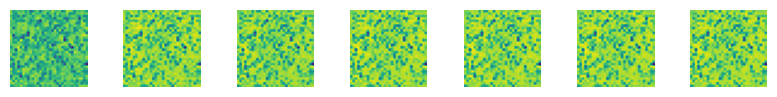

ic| x.shape: torch.Size([1, 1, 32, 32])
    x.squeeze(0).shape: torch.Size([1, 32, 32])


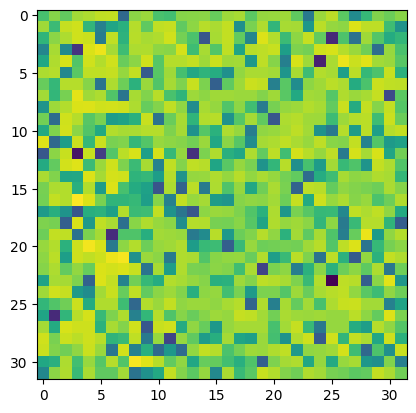

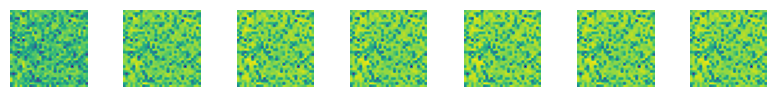

ic| x.shape: torch.Size([1, 1, 32, 32])
    x.squeeze(0).shape: torch.Size([1, 32, 32])


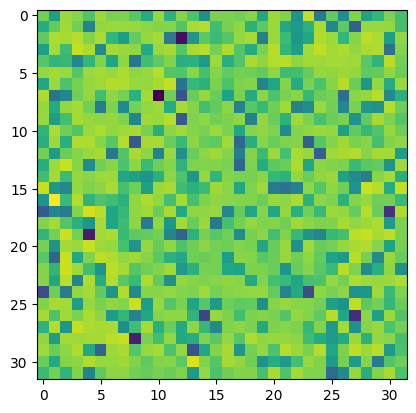

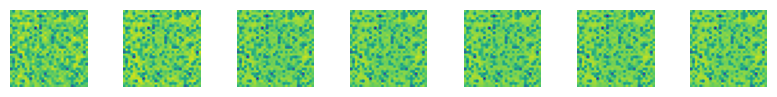

ic| x.shape: torch.Size([1, 1, 32, 32])
    x.squeeze(0).shape: torch.Size([1, 32, 32])


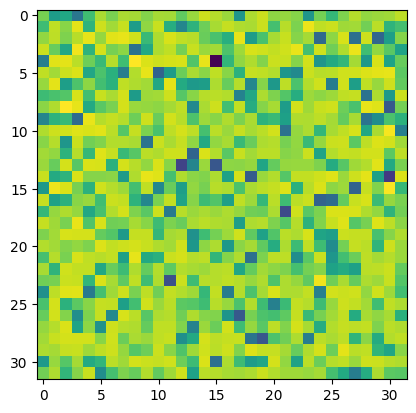

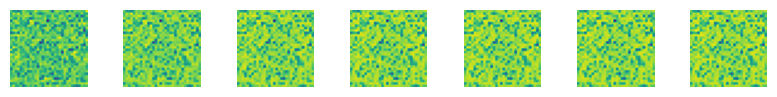

ic| x.shape: torch.Size([1, 1, 32, 32])
    x.squeeze(0).shape: torch.Size([1, 32, 32])


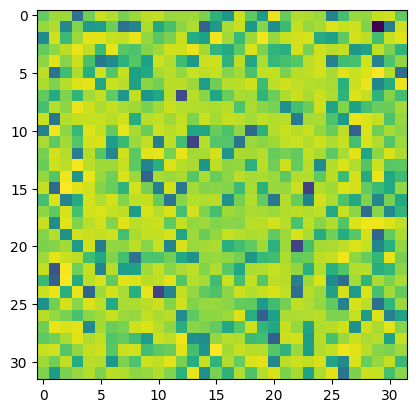

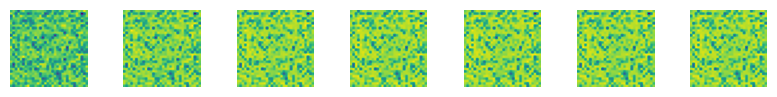

ic| x.shape: torch.Size([1, 1, 32, 32])
    x.squeeze(0).shape: torch.Size([1, 32, 32])


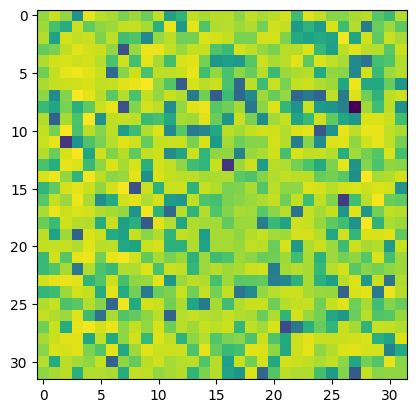

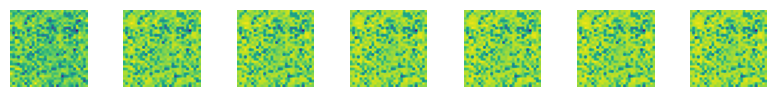

ic| x.shape: torch.Size([1, 1, 32, 32])
    x.squeeze(0).shape: torch.Size([1, 32, 32])


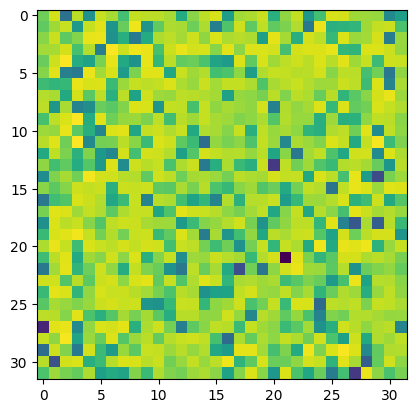

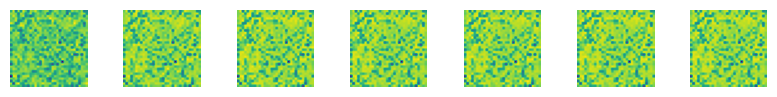

ic| x.shape: torch.Size([1, 1, 32, 32])
    x.squeeze(0).shape: torch.Size([1, 32, 32])


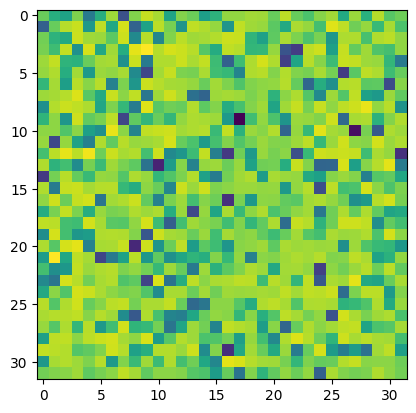

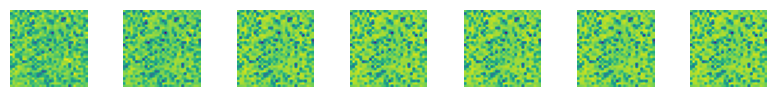

ic| x.shape: torch.Size([1, 1, 32, 32])
    x.squeeze(0).shape: torch.Size([1, 32, 32])


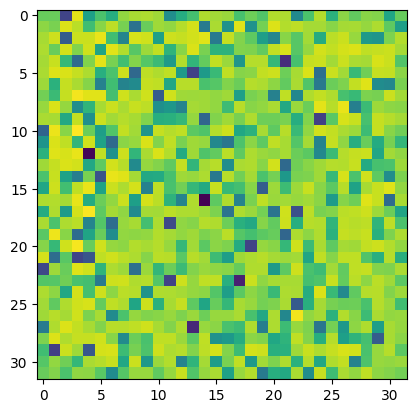

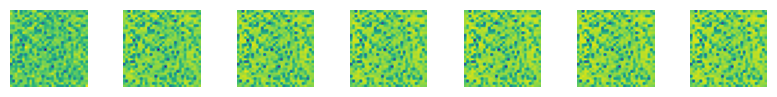

In [32]:
def display_reverse(images: list):
    fig, axes = plt.subplots(1, len(images), figsize=(10,1))
    for i, ax in enumerate(axes.flat):
        x = images[i].squeeze(0)
        #x = torch.rearrange(x, 'c h w -> h w c')
        x = x.permute(1,2,0)
        x = x.numpy()
        ax.imshow(x)
        ax.axis('off')
    plt.show()

scheduler = DDPM_Scheduler(num_time_steps=num_time_steps)
times = [0,15,50,100,200,300,400,500]
images = []
with torch.no_grad():
    model = model.eval()
    for i in range(10):
        z = torch.randn(1, 1, 32, 32)
        for t in reversed(range(1, num_time_steps)):
            t = [t]
            temp = (scheduler.beta[t]/( (torch.sqrt(1-scheduler.alpha[t]))*(torch.sqrt(1-scheduler.beta[t])) ))
            z = (1/(torch.sqrt(1-scheduler.beta[t])))*z - (temp*model(z.to(device),t=[0]).cpu())
            if t[0] in times:
                images.append(z)
            e = torch.randn(1, 1, 32, 32)
            z = z + (e*torch.sqrt(scheduler.beta[t]))
        temp = scheduler.beta[0]/( (torch.sqrt(1-scheduler.alpha[0]))*(torch.sqrt(1-scheduler.beta[0])) )
        x = (1/(torch.sqrt(1-scheduler.beta[0])))*z - (temp*model(z.to(device),t=[0]).cpu())

        images.append(x)
        #x = torch.rearrange(x.squeeze(0), 'c h w -> h w c').detach()
        ic(x.shape, x.squeeze(0).shape)
        x = x.squeeze(0).permute( 1,2,0).detach()
        x = x.numpy()
        plt.imshow(x)
        plt.show()
        display_reverse(images)
        images = []

### Train the UNet model

Difference with DDPM method.

The training objective is different, involving predicting the noise rather than the denoised image

The model is conditioned on the amount of noise present via timestep conditioning, where t is passed as an additional argument to the forward method.

In [ ]:
model_version = "0.1"
model_name = "mnist_diffus"


# Dataloader (you can mess with batch size)
batch_size = 128
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# How many runs through the data should we do?
n_epoch = 3

# Create the network
model = BasicUNet()
model.to(device)

# Our loss function
loss_fn = nn.MSELoss()

# The optimizer
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

# Keeping a record of the losses for later viewing
losses = []

do_train: bool = True
last_update_epoch = 0

if do_train:
    writer = SummaryWriter(
        f"../runs/{model_name}_{model_version}/{datetime.now().strftime('%m-%d-%Y_%H:%M:%S')}"
    )
    # The training loop
    nb_batches = len(train_dataloader)
    with tqdm(
        total=n_epoch * nb_batches,
        desc=f"Training update",
        unit="batch",
    ) as pbar:
        for epoch in range(n_epoch):
            for batch_nb, (x, y) in enumerate(train_dataloader):
                # Get some data and prepare the corrupted version
                x = x.to(device)  # Data on the GPU
                noise_amount = torch.rand(x.shape[0]).to(
                    device
                )  # Pick random noise amounts
                noisy_x = corrupt(x, noise_amount)  # Create our noisy x

                # Get the model prediction
                pred = model(noisy_x)

                # Calculate the loss
                loss = loss_fn(
                    pred, x
                )  # How close is the output to the true 'clean' x?

                # Backprop and update the params:
                opt.zero_grad()
                loss.backward()
                opt.step()

                # Store the loss for later
                losses.append(loss.item())

                pbar.update(1)
                pbar.set_postfix(
                    {
                        "epoch": epoch,
                        "batch_nb": batch_nb,
                        "train_loss": f"{loss.item():.4f}",
                    }
                )
                writer.add_scalar(f"train loss", loss.item(), (epoch*nb_batches) + batch_nb)

            for name, kernel_weight in model.named_parameters():
                writer.add_histogram(name, kernel_weight, epoch)

            # Print our the average of the loss values for this epoch:
            avg_loss = sum(losses[nb_batches :]) / nb_batches
            # print(f"Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}")

    # View the loss curve
    plt.plot(losses)
    plt.ylim(0, 0.25)


    save_model(model=model, model_name=model_name, model_version=model_version, iter=epoch)
else:
    model = load_model(model_name=model_name, model_version=model_version, iter=last_update_epoch)


ic| ux.shape: torch.Size([8, 1, 28, 28])


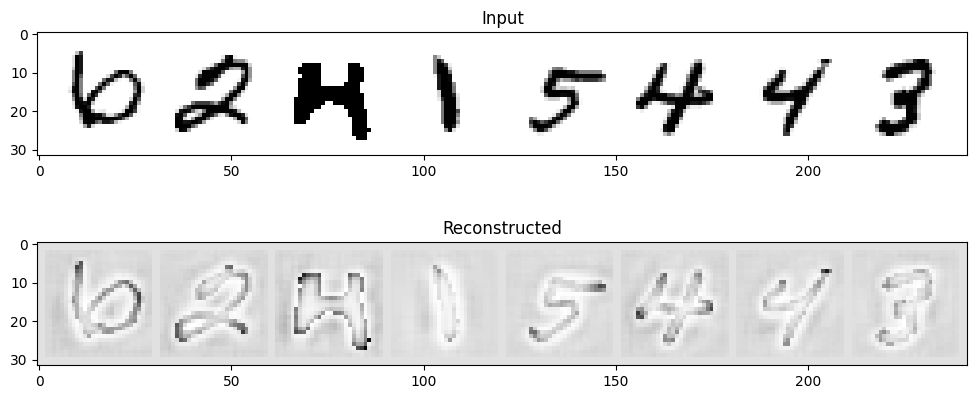

In [36]:
# Reconstruction without any noise added.

dl = DataLoader(dataset, batch_size=8, shuffle=True)
x, y = next(iter(dl))
with torch.no_grad():
    ux = model(x.to(device))
    ic(ux.shape)

fig, axs = plt.subplots(2, 1, figsize=(12, 5))
axs[0].set_title("Input")
axs[0].imshow(torchvision.utils.make_grid(x)[0], cmap="Greys")
axs[1].set_title("Reconstructed")
axs[1].imshow(torchvision.utils.make_grid(ux.cpu())[0], cmap="Greys")

In [ ]:
# Corrupt with a range of amounts
amount = torch.linspace(0, 1, x.shape[0])  # Left to right -> more corruption
noised_x = corrupt(x, amount)

# Get the model predictions
with torch.no_grad():
    preds = model(noised_x.to(device)).detach().cpu()

# Plot
fig, axs = plt.subplots(3, 1, figsize=(12, 7))
axs[0].set_title("Input data")
axs[0].imshow(torchvision.utils.make_grid(x)[0].clip(0, 1), cmap="Greys")
axs[1].set_title("Corrupted data")
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0].clip(0, 1), cmap="Greys")
axs[2].set_title("Network Predictions")
axs[2].imshow(torchvision.utils.make_grid(preds)[0].clip(0, 1), cmap="Greys")

In [ ]:
# @markdown Sampling strategy: Break the process into 5 steps and move 1/5'th of the way there each time:
n_steps = 5
x = torch.rand(8, 1, 28, 28).to(device)  # Start from random
step_history = [x.detach().cpu()]
pred_output_history = []

for i in range(n_steps):
    with torch.no_grad():  # No need to track gradients during inference
        pred = model(x)  # Predict the denoised x0
    pred_output_history.append(pred.detach().cpu())  # Store model output for plotting
    mix_factor = 1 / (n_steps - i)  # How much we move towards the prediction
    x = x * (1 - mix_factor) + pred * mix_factor  # Move part of the way there
    step_history.append(x.detach().cpu())  # Store step for plotting

fig, axs = plt.subplots(n_steps, 2, figsize=(9, 4), sharex=True)
axs[0, 0].set_title("x (model input)")
axs[0, 1].set_title("model prediction")
for i in range(n_steps):
    axs[i, 0].imshow(torchvision.utils.make_grid(step_history[i])[0].clip(0, 1), cmap="Greys")
    axs[i, 1].imshow(torchvision.utils.make_grid(pred_output_history[i])[0].clip(0, 1), cmap="Greys")